In [1]:
import IPython.display as disp

from sympy import symbols, Matrix, Eq, Function

from sympy import sympify
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import Vector, divergence, curl
from sympy.physics.mechanics import ReferenceFrame, Point, Particle
from sympy import diff
##from sympy.physics.mechanics import LagrangesMethod, Lagrangian, KanesMethod
from sympy.physics.mechanics import mechanics_printing
mechanics_printing(pretty_print=True) # Shinny


# Mechanical formalism for tissue dynamics

Sham Tlili, Cyprien Gay, Francois Graner, Philippe Marcq, Francois
Molino, Pierre Saramito

[arxiv:1309.7432v2](http://arxiv.org/abs/1309.7432v2)


A sympy implementation.


## Section II

### B. Choice of formalism

#### 1. Rheological diagram

It is natural to mirror the rheological diagram with a class diagram in python


Oldroyd viscoelastic fluid

![Oldroyd](oldroyd.svg)

In [2]:
def indexer(name, index=None, expo=None):
    '''Small utility to append an index  and
    an exponent to the string `name`
    '''
    
    if index:
        name = name + '_{}'.format(index)
    if expo:
        name = name + '^{}'.format(expo)
    return name

    

def deformation_symbol(index=None, expo=None):
    return dynamicsymbols(indexer('epsilon', index, expo))

def stress_symbol(index=None, expo=None):
    return dynamicsymbols(indexer('sigma',index, expo))

def viscosity_symbol(index=None, expo=None):
    return symbols(indexer('eta', index, expo),
                   positive=True, real=True)

def stiffness_symbol(index=None, expo=None):
    return symbols(indexer('G', index, expo),
                   positive=True, real=True)


class Element:

    def __init__(self, index):
        self.deformation = deformation_symbol(index)
        self.stress = stress_symbol(index)
        
    @property
    def rheol_equations(self):
        raise NotImplementedError
        
class Spring(Element):
    '''
    A simple spring
    
    Attributes
    ----------
    stiffness: :class:`sympy.symbols`
        assumed positive, real and independant of time
    
    '''
    def __init__(self, index):
        '''
        creates a spring indexed by `index`
        
        Parameters
        ----------
        index: int or str
          passed to the `format` method
        '''
        super().__init__(index)
        self.stiffness = stiffness_symbol(index)
    
    @property
    def rheol_equations(self):
        return Matrix([self.stress - self.stiffness * self.deformation,])

        
class Dashpot(Element):
    '''
    A simple dashpot
    '''
    def __init__(self, index):
        '''
        creates a dashpot indexed by `index`
        
        Parameters
        ----------
        index: int or str
          passed to the `format` method
        '''
        super().__init__(index)
        self.viscosity = viscosity_symbol(index)
    
    @property
    def rheol_equations(self):
        return Matrix([self.stress - self.viscosity * self.deformation.diff(),])

        
class Maxwell_element(Element):
    '''
    A spring in series with a dashpot
    '''
    def __init__(self, index):
        super().__init__(index)
        self.spring = Spring('{}{}'.format(index, 1))
        self.dashpot = Dashpot('{}{}'.format(index, 2))

    @property
    def rheol_equations(self):
        r_eq = list(self.spring.rheol_equations) + list(self.dashpot.rheol_equations)
        r_eq.append(self.deformation - 
                    (self.spring.deformation 
                     + self.dashpot.deformation))
        r_eq = Matrix(r_eq)
        ### spring and dashpot carry the same stress
        r_eq = r_eq.subs({self.spring.stress: self.stress,
                          self.dashpot.stress: self.stress})

        return r_eq
    
class Oldroyd(Element):
    
    def __init__(self, index):
        super().__init__(index)
        self.maxwell = Maxwell_element('{}{}'.format(index, 1))
        self.dashpot = Dashpot('{}{}'.format(index, 2))
    
    @property
    def rheol_equations(self):
        ''' List of expressions equal to zero
        Eq. (1) in the article
        '''
        r_eq = list(self.maxwell.rheol_equations) + list(self.dashpot.rheol_equations)
        r_eq = Matrix(r_eq)
        r_eq.subs({self.maxwell.deformation: self.deformation,
                   self.dashpot.deformation: self.deformation})
        return r_eq
        

    ### Maybe this can be constructed from rheol_equations
    def constitutive_equation(self):
        ''' 
        Returns the constitutive equation as as `sympy.Eq` object
        Eq. (2) of the article
        '''
        
        stress_term = self.stress.diff() + (self.maxwell.spring.stiffness 
                                            / self.dashpot.viscosity) * self.stress
        viscous_term = (((self.maxwell.dashpot.viscosity + self.dashpot.viscosity)
                         / self.maxwell.dashpot.viscosity) 
                        * self.maxwell.spring.stiffness * self.deformation.diff()
                        + self.dashpot.viscosity * self.deformation.diff().diff())
       
        return Eq(stress_term, viscous_term)

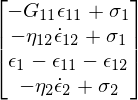

In [3]:
oldroyd = Oldroyd('')
oldroyd.rheol_equations

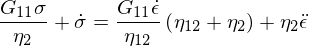

In [4]:
oldroyd.constitutive_equation()

#### 3 Dissipation function formalism



In [5]:
epsilon = dynamicsymbols('epsilon') # total deformation
### We set the number of variables to 4, to ease representation
m = 4 ## Number of internal varialbles
epsilons = dynamicsymbols('epsilon:{}'.format(m))
epsilonsd = dynamicsymbols('epsilon:{}'.format(m), 1)

### Eqs. (3), (4)
E = Function('E')(epsilon, *epsilons)
D = Function('D')(epsilon.diff(), *epsilonsd)

### See Appendix B for tensorial case

sigma = symbols('sigma')

### Eqs (5), (6)
constitutive_equation = Eq(sigma, diff(D, epsilon.diff()) + diff(E, epsilon))
evolution_equations = Matrix([diff(D, epsilons[k].diff()) + diff(E, epsilons[k])
                              for k in range(m)])

In [6]:
E, D

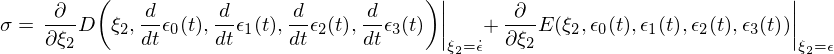

In [7]:
constitutive_equation 

* If only spring, dashpots and sliders: equiv. to rheological model.
* If $D$ a quadratic function of its aguments $\rightarrow$ hydrodynamical formalism

### C.  Specificity of cellular material modeling

#### 1. Intra-cell and inter-cell deformation

Decomposition of the tissue deformation rate into intra (constituent cells) and inter (cell-cell relative speeds).

![in_out_decomposition](in_out_decomposition.svg)

* Total deformation $\epsilon$: followed by **markers** moving with the tissue
* intra cellular deformation $\epsilon_{intra}$:
 > anisotropy of a group of **tracers** attached to a reference frame and its
   neighbours, followed by an average over reference cells.
   [...] _not attached to the tissue_ [...]
* inter cellular deformation $\epsilon_{intra}$: cell rearrengements & relative movements -> tracking rearrangements themselves

Compact tissue $\Rightarrow$ tissue stress $\sigma$ is equal to cell's stress.

In [8]:
### Decomposition in series
e_intra = dynamicsymbols('epsilon_intra')
e_inter = dynamicsymbols('epsilon_inter')
eq_9 = Eq(epsilon.diff(), e_inter + e_intra)
eq_9

##### Eulerian description

$$
\dot{\epsilon} = \frac{\nabla \vec{v} + \nabla \vec{v}^T}{2}
$$

##### Parameters and variables

Those are [**fields**](http://docs.sympy.org/dev/modules/physics/vector/fields.html)

#### Momentum conservation

$\nabla \sigma(\vec{x}, t) + \vec{f}(\vec{x}, t) = \vec{0}$


In [9]:
R = ReferenceFrame('R')
t = symbols('t')

## Ingredients included in tissue modeling

>A (non-exhaustive) list of ingredients for tissue modelling 
includes viscosity, elasticity, plasticity, growth, 
contractility, chemical concentration fields, cell polarity, and
their feedbacks.

### Plasticity